#### 1. Import the Relevent Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Mar 27 16:42:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!unzip -q "/content/drive/MyDrive/IT350/Copy of dataset_rgb.zip"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchsummary import summary
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#### 2. Prepare the Dataset

In [ ]:
class MyDataset(Dataset):

    def __init__(self, root, transform_status=True):

        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")]
        import itertools
        self.images_paths = list(itertools.chain.from_iterable(self.images_paths))
        import random
        random.shuffle(self.images_paths)
        self.classes_names = {class_name:label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]
        self.transform_status = transform_status
        self.transform = transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, index):
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]
        image = cv2.resize(image, (64,64))
        image = torch.tensor(image/255).permute(2,0,1)
        if self.transform_status: image = self.transform(image)
        label = self.labels[index]

        return image.float().to(device), torch.tensor([label]).float().to(device)

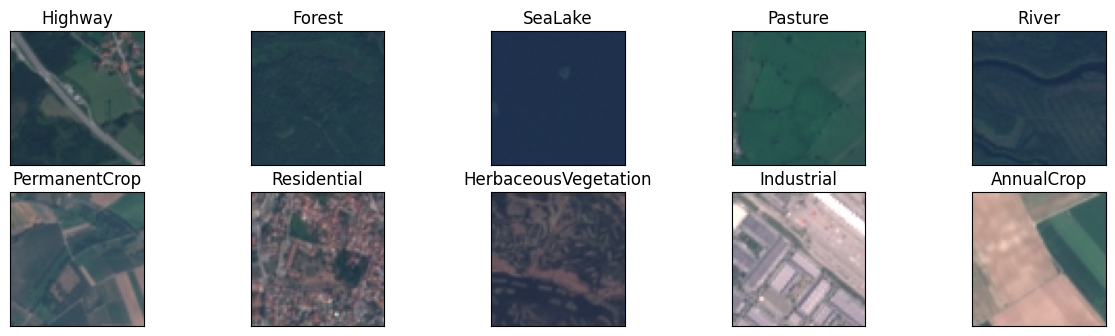

In [ ]:
import PIL
import seaborn as sns
import matplotlib.pyplot as plt
DATASET = "dataset_rgb/train"
LABELS = ['Highway', 'Forest', 'SeaLake', 'Pasture', 'River', 'PermanentCrop', 'Residential', 'HerbaceousVegetation', 'Industrial', 'AnnualCrop']
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [ ]:
data =  MyDataset("dataset_rgb/train", transform_status=False)
Train_DATASET = "dataset_rgb/train"
LABELS = os.listdir(Train_DATASET)
print(LABELS)

['Industrial', 'River', 'HerbaceousVegetation', 'AnnualCrop', 'SeaLake', 'Pasture', 'PermanentCrop', 'Forest', 'Highway', 'Residential']


In [ ]:
# print(data)
print(data.transform)

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


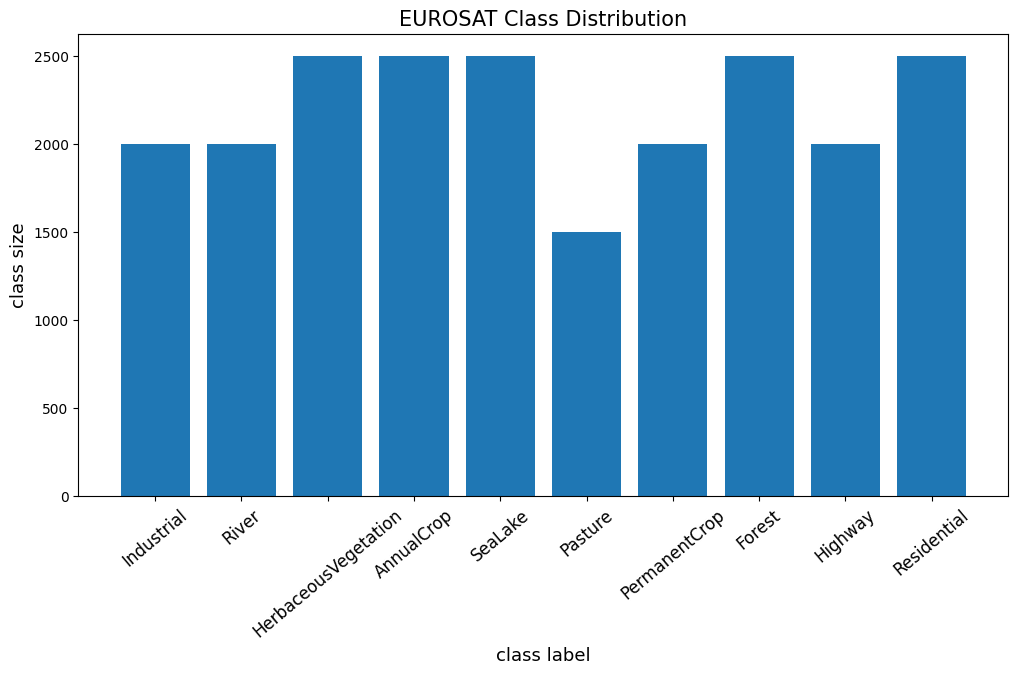

In [ ]:
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(Train_DATASET, l)))
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

['Industrial', 'River', 'HerbaceousVegetation', 'AnnualCrop', 'SeaLake', 'Pasture', 'PermanentCrop', 'Forest', 'Highway', 'Residential']


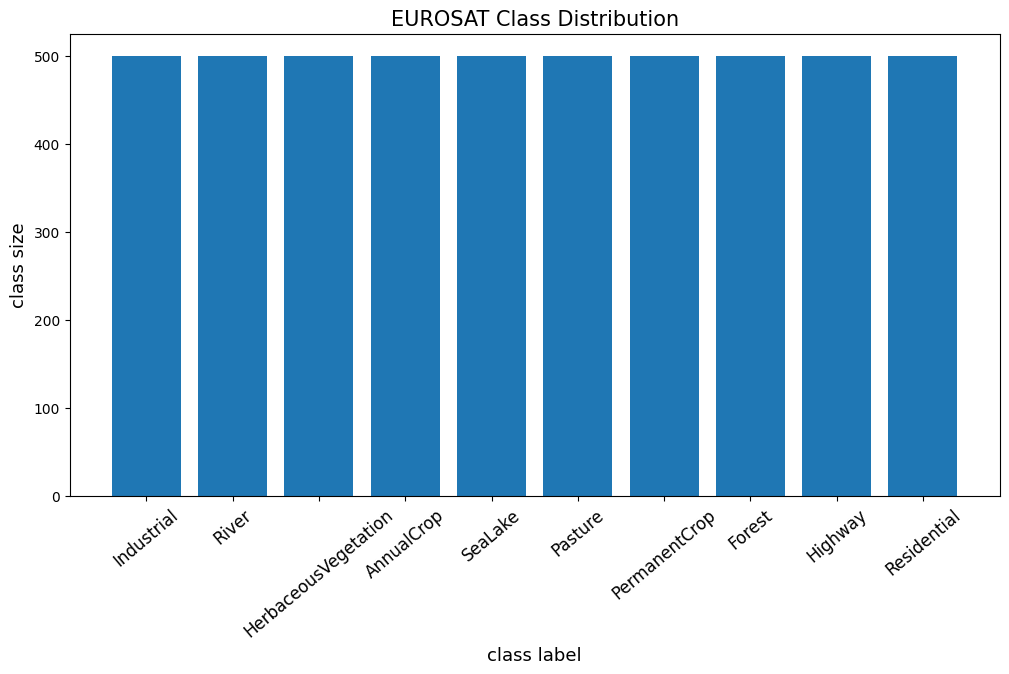

In [ ]:
Test_DATASET = "dataset_rgb/test"
LABELS = os.listdir(Test_DATASET)
print(LABELS)
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(Test_DATASET, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [ ]:
data.classes_names

{'Industrial': 0,
 'River': 1,
 'HerbaceousVegetation': 2,
 'AnnualCrop': 3,
 'SeaLake': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Forest': 7,
 'Highway': 8,
 'Residential': 9}

In [ ]:
import random
image, label = data[random.randint(0, len(data))]

Image Size: 64 x 64 x 3
Label: tensor([1.], device='cuda:0')
River


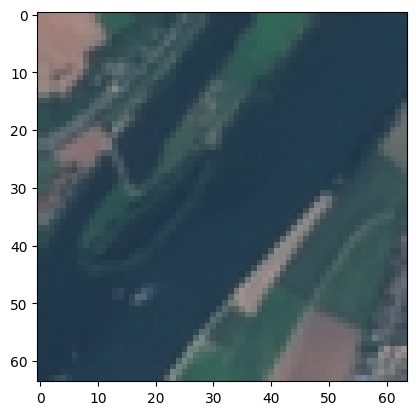

In [ ]:
print(f"Image Size: {image.shape[2]} x {image.shape[1]} x {image.shape[0]}")
print(f"Label: {label}")
print([key  for key, value in data.classes_names.items() if value == label][0])
plt.imshow(image.permute(1,2,0).cpu().numpy())
plt.show()
# image.classes_names

In [ ]:
train_dataset = MyDataset("dataset_rgb/train", transform_status=True)
test_dataset = MyDataset("dataset_rgb/test", transform_status=True)
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

**Model architecture**:

* CNN with three layers (32, 64, 128)
* Kernel size: 5x5 (padding: 2)
* Max pooling after each layer

* Fully connected NN with three layers (2048, 2048, 10)
* Activation function: ReLu (last layer: Softmax)


In [ ]:
class EurosatNet(nn.Module):
    def __init__(self):
        super(EurosatNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(128 * 8 * 8, 2048, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(2048, 2048, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.linear3 = nn.Linear(2048, 10)
        self.relu3 = nn.ReLU(inplace=True)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self, images):
        x = self.pool1(self.relu1(self.conv1(images)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 128*8*8)
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.logsoftmax(self.linear3(x))
        return x

## **. Neural Network Training**
* Loss: negative log-likelihood
* Optimizer: SGD
* Number of parameters: 21,518,474
* Learning rate: 0.001
* Epochs: 200
* Batch size: 64

In [ ]:
#define loss function and push it to enabled device
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

In [ ]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

In [ ]:
# specify the training parameters
num_epochs = 200 # number of training epochs
mini_batch_size = 64 # size of the mini-batches

In [ ]:
# transform training data to pytorch dataset
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)

In [ ]:
# transform test data to pytorch dataset
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

In [ ]:
# specifiy and instantiate PyTorch data loader that feeds the image tensors to our neural network
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=True)

In [ ]:
#define function to display accracy after each epoch during network training
def get_accuracy(output, labels):
  """Input: Tensor with Output/Predictions, True labels
    Calculates classification accuracy for given output
    Output: float: accuracy"""

  _, predicted = torch.max(output.data, 1)
  total = labels.size(0)
  correct = (predicted == labels).sum().item()
  accuracy = correct / total
  return accuracy

In [ ]:
# init collection of training epoch losses
train_epoch_losses = []
test_epoch_losses = []
train_epoch_accuracies = []
test_epoch_accuracies = []

# set the model in training mode
model.train()

# train the model
for epoch in range(num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []
    test_mini_batch_losses = []
    train_mini_batch_accuracy = []
    test_mini_batch_accuracy = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):

        #push batch on gpu
        labels=labels.to(device, dtype = torch.int64)
        images = images.to(device, dtype = torch.float32)


        # run forward pass through the network
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        # determine classification loss and accuracy
        loss = nll_loss(output, labels)
        accuracy = get_accuracy(output, labels)

        # run backward pass
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
        train_mini_batch_accuracy.append(accuracy)

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.round(np.mean(train_mini_batch_losses),4)
    train_epoch_accuracy = np.round(np.mean(train_mini_batch_accuracy),4)

    #do the same as above for our own test set
    with torch.no_grad():
      for i, (images, labels) in enumerate(test_dataloader):
        labels=labels.to(device, dtype = torch.int64)
        images = images.to(device, dtype = torch.float32)
        output = model(images)
        loss = nll_loss(output, labels)
        accuracy = get_accuracy(output, labels)
        test_mini_batch_losses.append(loss.data.item())
        test_mini_batch_accuracy.append(accuracy)
      test_epoch_loss = np.round(np.mean(test_mini_batch_losses),4)
      test_epoch_accuracy = np.round(np.mean(test_mini_batch_accuracy),4)

    # print epoch loss and accuracy of training and test set
    # now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print(' : {} train-loss: {} eval-loss: {} train-acc: {} test-acc: {} '.format(str(now), str(epoch), str(train_epoch_loss), str(test_epoch_loss), str(train_epoch_accuracy), str(test_epoch_accuracy)))

    # save model to local directory
    model_name = 'eurosat_model_epoch_{}.pth'.format(str(epoch))
    info_dict = {
    'epoch' : epoch,
    'net_state' : model.state_dict(),
    'optimizer_state' : optimizer.state_dict()}
    torch.save(info_dict, os.path.join("./ConvNet/models_eurosat", model_name))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(test_epoch_loss)

    train_epoch_accuracies.append(train_epoch_accuracy)
    test_epoch_accuracies.append(test_epoch_accuracy)

: 0 train-loss: 2.2482 eval-loss: 2.0662 train-acc: 0.1802 test-acc: 0.1155
: 1 train-loss: 1.8235 eval-loss: 1.5329 train-acc: 0.3341 test-acc: 0.4203
: 2 train-loss: 1.297 eval-loss: 1.1421 train-acc: 0.5201 test-acc: 0.5601
: 3 train-loss: 1.0893 eval-loss: 1.0317 train-acc: 0.5734 test-acc: 0.5856
: 4 train-loss: 0.9941 eval-loss: 0.9502 train-acc: 0.6089 test-acc: 0.6259
: 5 train-loss: 0.9223 eval-loss: 0.8865 train-acc: 0.6416 test-acc: 0.6676
: 6 train-loss: 0.8552 eval-loss: 0.8262 train-acc: 0.6725 test-acc: 0.687
: 7 train-loss: 0.7787 eval-loss: 0.7316 train-acc: 0.7181 test-acc: 0.7513
: 8 train-loss: 0.688 eval-loss: 0.6572 train-acc: 0.7566 test-acc: 0.7688
: 9 train-loss: 0.6091 eval-loss: 0.6055 train-acc: 0.7851 test-acc: 0.7765
: 10 train-loss: 0.5297 eval-loss: 0.528 train-acc: 0.8184 test-acc: 0.8275
: 11 train-loss: 0.4676 eval-loss: 0.4476 train-acc: 0.8405 test-acc: 0.8479
: 12 train-loss: 0.4261 eval-loss: 0.4126 train-acc: 0.8559 test-acc: 0.8608
: 13 train-lo

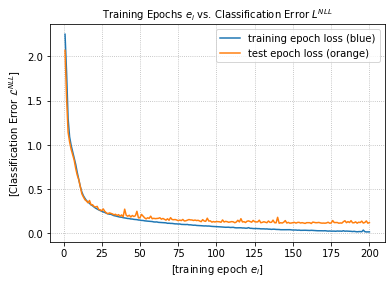

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='training epoch loss (blue)')
ax.plot(np.array(range(1, len(test_epoch_losses)+1)), test_epoch_losses, label='test epoch loss (orange)')


# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

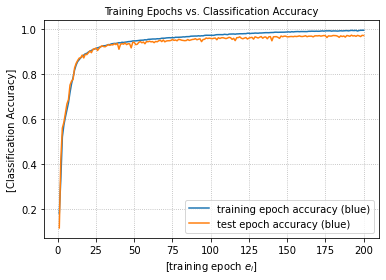

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_accuracies)+1)), train_epoch_accuracies, label='training epoch accuracy (blue)')
ax.plot(np.array(range(1, len(test_epoch_accuracies)+1)), test_epoch_accuracies, label='test epoch accuracy (blue)')


# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Accuracy]", fontsize=10)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs vs. Classification Accuracy', fontsize=10);

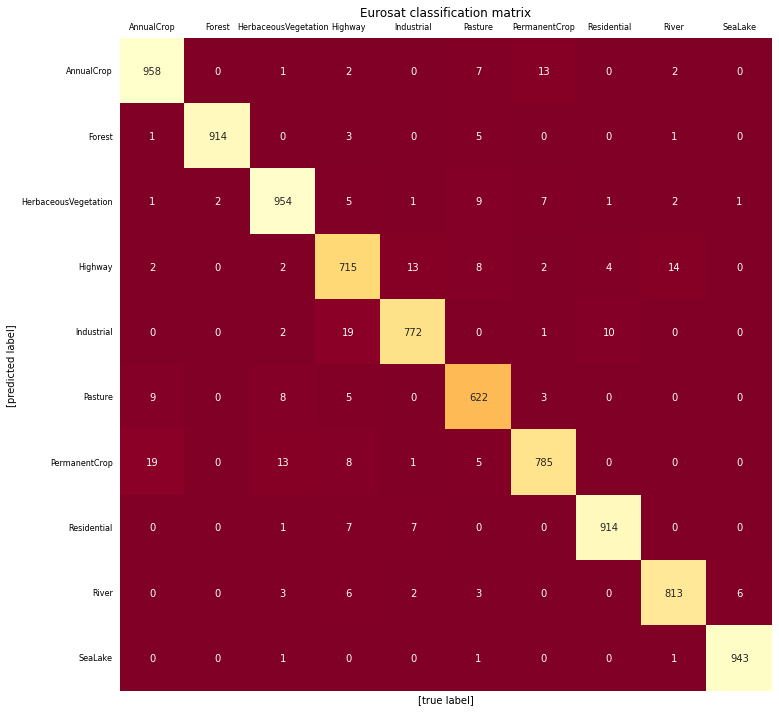

In [ ]:
import seaborn as sns

# determine classification matrix of the predicted and target classes
mat = confusion_matrix(pred_labels, predictions)

# initialize the plot and define size
plt.figure(figsize=(12, 12))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=classes, yticklabels=classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('Eurosat classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

## VGG Model Architechture

In [ ]:
def build_model():
    vgg19 = models.vgg19(pretrained=True)
    for param in vgg19.parameters():
        param.requires_grad = False
    vgg19.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    vgg19.classifier = nn.Sequential(   nn.Flatten(),
                                        nn.Linear(512, 128),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(128, 10))
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(vgg19.parameters(), lr=1e-3)

    return vgg19.to(device), loss_function, optimizer

In [ ]:
model , loss_function, optimizer = build_model()

In [ ]:
summary(model, tuple(torch.zeros(3, 64, 64).size()))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

#### 4. Build the Train and Accuracy Functions

In [ ]:
def train_batch(model, loss_function, optimizer, image, label):
    model.train()
    optimizer.zero_grad()
    prediction = model(image)
    loss = loss_function(prediction, label.long().squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
@torch.no_grad()
def accuracy(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == label.long().squeeze()
    return is_correct.cpu().numpy().tolist()

In [ ]:
@torch.no_grad()
def validation_loss(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    loss = loss_function(prediction, label.long().squeeze())
    return loss.item()

#### 5. Train the Model

In [ ]:
plot_history(resnet50_history)

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(25):
    print(f"Epoch: {epoch+1}")
    train_epoch_losses = []
    train_epoch_accuracies = []
    for image, label in iter(train_dataset_loader):
        loss = train_batch(model, loss_function, optimizer, image, label)
        train_epoch_losses.append(loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    train_losses.append(train_epoch_loss)

    for image, label in iter(train_dataset_loader):
        is_correct = accuracy(model, loss_function, image, label)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy: {train_epoch_accuracy*100:.2f}%")
    train_accuracies.append(train_epoch_accuracy)

    test_epoch_losses = []
    test_epoch_accuracies = []
    for image, label in iter(test_dataset_loader):
        loss = validation_loss(model, loss_function, image, label)
        test_epoch_losses.append(loss)
        is_correct = accuracy(model, loss_function, image, label)
        test_epoch_accuracies.extend(is_correct)
    test_epoch_loss = np.mean(test_epoch_losses)
    print(f"Test Loss: {test_epoch_loss:.4f}")
    test_losses.append(test_epoch_loss)
    test_epcoh_accuracy = np.mean(test_epoch_accuracies)
    print(f"Test Accuracy: {test_epcoh_accuracy*100:.2f}%")
    test_accuracies.append(test_epcoh_accuracy)


Epoch: 1
Train Loss: 0.4537
Train Accuracy: 90.48%
Test Loss: 0.3582
Test Accuracy: 87.26%
Epoch: 2
Train Loss: 0.2855
Train Accuracy: 92.42%
Test Loss: 0.3275
Test Accuracy: 88.94%
Epoch: 3
Train Loss: 0.2472
Train Accuracy: 93.09%
Test Loss: 0.3267
Test Accuracy: 88.78%
Epoch: 4
Train Loss: 0.2236
Train Accuracy: 93.78%
Test Loss: 0.3204
Test Accuracy: 89.22%
Epoch: 5
Train Loss: 0.2032
Train Accuracy: 94.80%
Test Loss: 0.3148
Test Accuracy: 89.58%
Epoch: 6
Train Loss: 0.1814
Train Accuracy: 95.41%
Test Loss: 0.3061
Test Accuracy: 90.08%
Epoch: 7
Train Loss: 0.1674
Train Accuracy: 95.85%
Test Loss: 0.3222
Test Accuracy: 89.94%
Epoch: 8
Train Loss: 0.1532
Train Accuracy: 96.35%
Test Loss: 0.3267
Test Accuracy: 89.96%
Epoch: 9
Train Loss: 0.1416
Train Accuracy: 96.36%
Test Loss: 0.3358
Test Accuracy: 90.08%
Epoch: 10
Train Loss: 0.1312
Train Accuracy: 97.33%
Test Loss: 0.3310
Test Accuracy: 90.48%
Epoch: 11
Train Loss: 0.1186
Train Accuracy: 97.65%
Test Loss: 0.3368
Test Accuracy: 90.2

In [ ]:
def save_model(model, optimizer, filename='vgg19_model.pth'):
    # Save the model and optimizer state
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)
    print("Model saved successfully.")
save_model(model, optimizer)

#### 6. Visualize the Train Loss/Accuracy and the Test Loss/Accuracy

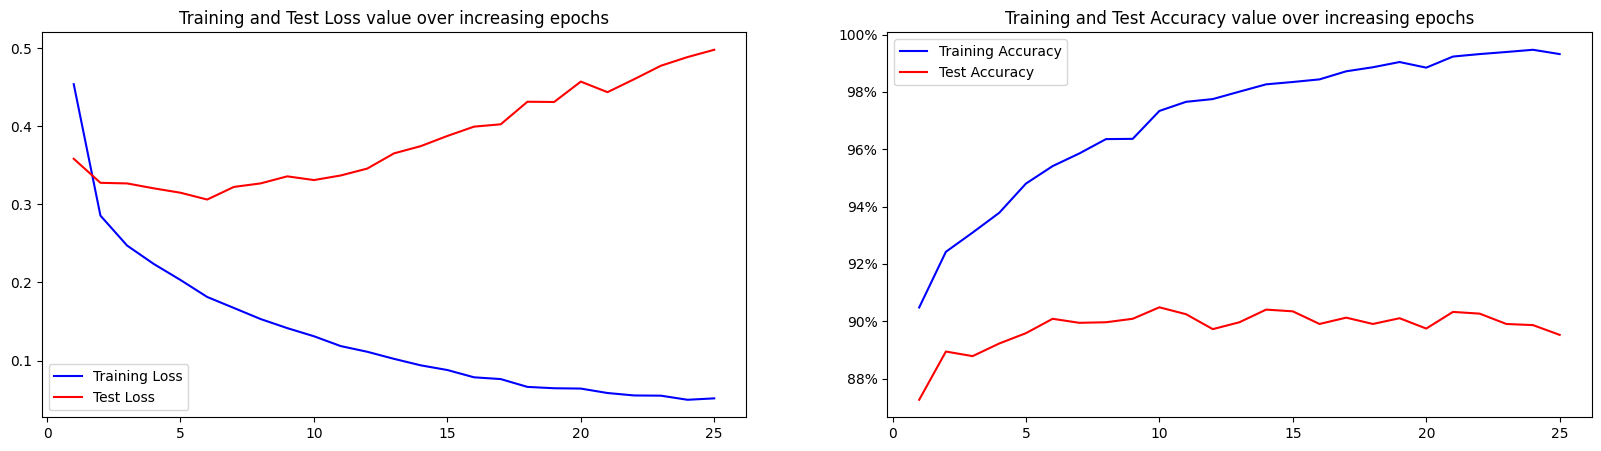

In [ ]:
epochs = np.arange(25)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Training and Test Loss value over increasing epochs')
plt.plot(epochs, train_losses,'b', label='Training Loss')
plt.plot(epochs, test_losses,'r', label='Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Training and Test Accuracy value over increasing epochs')
plt.plot(epochs, train_accuracies,'b', label='Training Accuracy')
plt.plot(epochs, test_accuracies,'r', label='Test Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

## ResNet50 Model


In [ ]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

In [ ]:
train_dataset_loader.reset()
test_dataset_loader.reset()

N_STEPS = train_dataset_loader.samples//BATCH_SIZE
N_VAL_STEPS = test_dataset_loader.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
resnet50_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

In [ ]:
# Save the model and the weights
resnet50_model.save('../working/ResNet50_eurosat.h5')

In [ ]:
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50V2_model.summary()

94674944/94668760 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 48s 142ms/step - loss: 2.5635 - categorical_accuracy: 0.5674 - val_loss: 1.1216 - val_categorical_accuracy: 0.3977

Epoch 00001: val_categorical_accuracy improved from -inf to 0.39769, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 41s 121ms/step - loss: 1.6108 - categorical_accuracy: 0.5957 - val_loss: 0.5727 - val_categorical_accuracy: 0.3868

Epoch 00002: val_categorical_accuracy did not improve from 0.39769
Epoch 3/50
337/337 [==============================] - 40s 119ms/step - loss: 1.4907 - categorical_accuracy: 0.6023 - val_loss: 0.6219 - val_categorical_accuracy: 0.4496

Epoch 00003: val_categorical_accuracy improved from 0.39769 to 0.44959, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 40s 120ms/step - loss: 1.4586 - categorical_accuracy: 0.6118 - val_loss: 1.1113 - val_categorical_accuracy: 0.3988

Epoch 0000

In [ ]:
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50V2_model.load_weights('/content/working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 77s 229ms/step - loss: 0.9749 - categorical_accuracy: 0.7247 - val_loss: 1.1145 - val_categorical_accuracy: 0.8090

Epoch 00001: val_categorical_accuracy improved from 0.47470 to 0.80897, saving model to ../working/model.weights.best.hdf5
Epoch 2/100
337/337 [==============================] - 57s 168ms/step - loss: 0.6212 - categorical_accuracy: 0.8236 - val_loss: 0.0551 - val_categorical_accuracy: 0.8789

Epoch 00002: val_categorical_accuracy improved from 0.80897 to 0.87894, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 57s 170ms/step - loss: 0.4617 - categorical_accuracy: 0.8649 - val_loss: 1.5127 - val_categorical_accuracy: 0.8508

Epoch 00003: val_categorical_accuracy did not improve from 0.87894
Epoch 4/100
337/337 [==============================] - 57s 169ms/step - loss: 0.3938 - categorical_accuracy: 0.8835 - val_loss: 1.5919 - val_categorical_accuracy: 0.8639

Epo

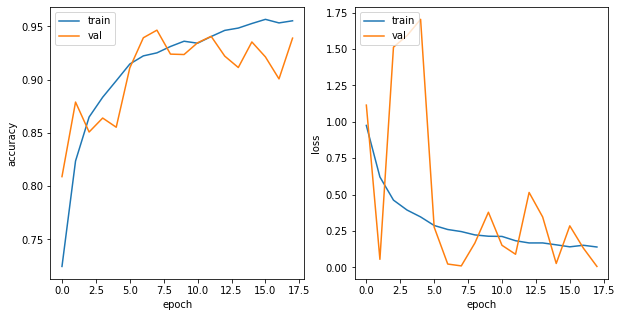

In [ ]:
plot_history(resnet50V2_history)

In [ ]:
resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9425925925925925
Global F2 Score: 0.9425925925925926


,Precision,Recall,F-Score,Support
AnnualCrop,0.846029,0.933810,0.887755,559.0
Forest,0.983471,0.983471,0.983471,605.0
HerbaceousVegetation,0.964419,0.895652,0.928765,575.0
Highway,0.909465,0.894737,0.902041,494.0
Industrial,0.976496,0.960084,0.968220,476.0
Pasture,0.956221,0.936795,0.946408,443.0
PermanentCrop,0.927152,0.878661,0.902256,478.0
Residential,0.951442,0.992089,0.971340,632.0
River,0.925403,0.925403,0.925403,496.0
SeaLake,0.984568,0.993769,0.989147,642.0


## Visualisation

In [ ]:
!unzip -q "/content/drive/MyDrive/IT350/earthimages(1).zip"

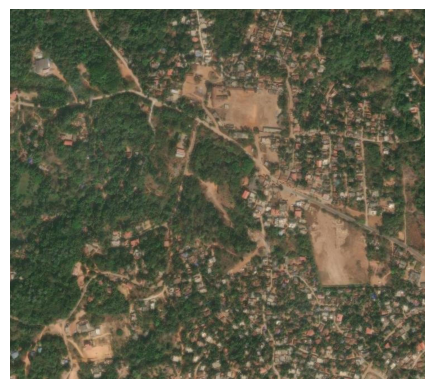

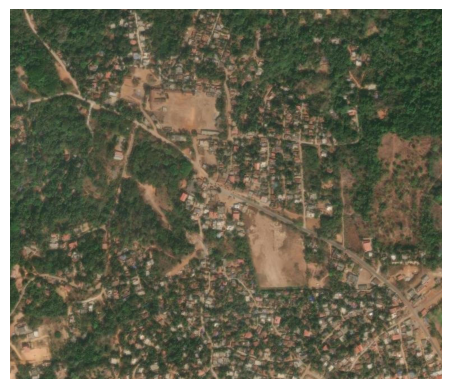

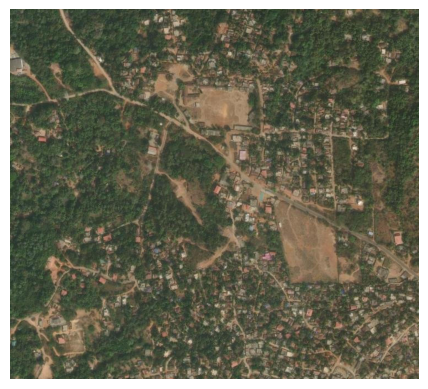

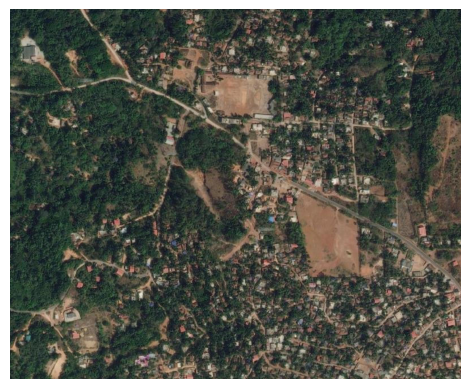

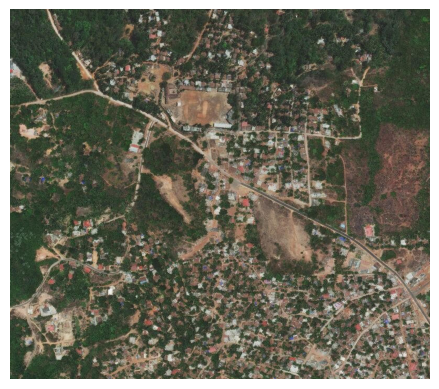

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the PNG image
png_image_paths = ['/content/Screenshot 2024-03-27 142141.png', '/content/Screenshot 2024-03-27 142207.png', '/content/Screenshot 2024-03-27 142225.png','/content/Screenshot 2024-03-27 142240.png','/content/Screenshot 2024-03-27 142253.png']  # Add more paths as needed

# Display each image
for image_path in png_image_paths:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
from PIL import Image
import os

In [ ]:
from PIL import Image
import os

# List of paths to PNG images
# png_image_paths = ['/path/to/image1.png', '/path/to/image2.png', '/path/to/image3.png']  # Add more paths as needed

# Output directory for resized images
output_dir = '/content/resized'  # Specify the output directory

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Size for resizing images
target_size = (640, 640)

# Convert each PNG image to TIFF format, resize it to 640x640 pixels, and ensure 3 channels (RGB)
for png_image_path in png_image_paths:
    # Open the PNG image
    png_img = Image.open(png_image_path)

    # Create the output TIFF image path
    tif_image_path = os.path.join(output_dir, os.path.splitext(os.path.basename(png_image_path))[0] + '.tif')

    # Convert and save as TIFF
    png_img.save(tif_image_path)

    # Open the TIFF image
    tif_img = Image.open(tif_image_path)

    # Ensure 3 channels (RGB)
    tif_img = tif_img.convert('RGB')

    # Resize the image
    resized_img = tif_img.resize(target_size)

    # Create the output path for the resized image
    resized_image_path = os.path.join(output_dir, os.path.basename(tif_image_path))

    # Save the resized image
    resized_img.save(resized_image_path)

    print(f"Converted {png_image_path} to {resized_image_path} and resized to {target_size} with 3 channels (RGB)")


Converted /content/Screenshot 2024-03-27 142141.png to /content/resized/Screenshot 2024-03-27 142141.tif and resized to (640, 640) with 3 channels (RGB)
Converted /content/Screenshot 2024-03-27 142207.png to /content/resized/Screenshot 2024-03-27 142207.tif and resized to (640, 640) with 3 channels (RGB)
Converted /content/Screenshot 2024-03-27 142225.png to /content/resized/Screenshot 2024-03-27 142225.tif and resized to (640, 640) with 3 channels (RGB)
Converted /content/Screenshot 2024-03-27 142240.png to /content/resized/Screenshot 2024-03-27 142240.tif and resized to (640, 640) with 3 channels (RGB)
Converted /content/Screenshot 2024-03-27 142253.png to /content/resized/Screenshot 2024-03-27 142253.tif and resized to (640, 640) with 3 channels (RGB)


In [ ]:
image_path = '/content/resized/Screenshot 2024-03-27 142141.tif'  # Replace with the path to your image

# Open the image
img = Image.open(image_path)

# Get information about the image
image_info = {
    'path': image_path,
    'size': img.size,  # (width, height) tuple
    'format': img.format,  # Image format (e.g., JPEG, PNG, TIFF)
    'mode': img.mode,  # Image mode (e.g., RGB, L)
    'info': img.info  # Additional image information (e.g., compression type)
}

# Print the image information
print("Image Information:")
for key, value in image_info.items():
    print(f"{key}: {value}")

Image Information:
path: /content/resized/Screenshot 2024-03-27 142141.tif
size: (640, 640)
format: TIFF
mode: RGB
info: {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}


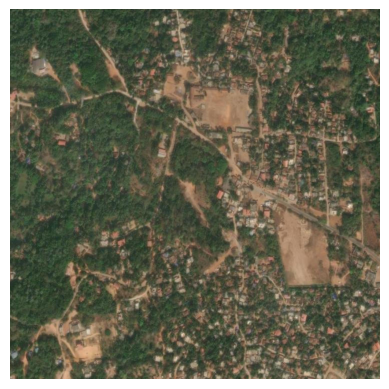

In [ ]:
tif_image_path = '/content/resized/Screenshot 2024-03-27 142141.tif'  # Replace with the path to your TIFF image

# Open the TIFF image
img = Image.open(tif_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
import numpy as np
from PIL import Image
import os

# Path to the TIFF image
tif_image_paths= ['/content/resized/Screenshot 2024-03-27 142141.tif','/content/resized/Screenshot 2024-03-27 142225.tif','/content/resized/Screenshot 2024-03-27 142240.tif','/content/resized/Screenshot 2024-03-27 142253.tif']  # Replace with the path to your TIFF image

# Open the TIFF image
img = Image.open(tif_image_path)

# Convert the image to a NumPy array
img_array = np.array(img)

# Define the size of the parts
part_size = 64

# Calculate the number of parts in each dimension
num_parts_x = img_array.shape[0] // part_size
num_parts_y = img_array.shape[1] // part_size

# Output directory for storing the parts
output_dir = '/content/divided_images_new3/image_1'  # Specify the output directory
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it does not exist

# Divide the image into 64x64 parts and save each part as an individual image
p =0
for k in tif_image_paths:
  output_dir = f'/content/divided_images_new3/image_{p}'  # Specify the output directory
  os.makedirs(output_dir, exist_ok=True)
  # Open the TIFF image
  img = Image.open(k)
  img_array = np.array(img)
  num_parts_x = img_array.shape[0] // part_size
  num_parts_y = img_array.shape[1] // part_size
  for i in range(num_parts_x):
      for j in range(num_parts_y):
          part = img_array[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size]
          part_img = Image.fromarray(part)
          part_img.save(os.path.join(output_dir, f'part_{i}_{j}.tif'))
  p+=1
print("Images saved successfully.")


Images saved successfully.


In [ ]:
from PIL import Image
import numpy as np

def load_image(image_path):
    """
    Load an image from the specified path and return it as a NumPy array.

    Args:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray: The image data as a NumPy array.
    """
    image = Image.open(image_path)
    image_data = np.array(image)
    return image_data

In [ ]:
# image_1 = transform('/content/divided_images_new3/2021/part_0_0.tif')
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])
image_1 = load_image('/content/divided_images_new3/2021/part_0_0.tif')
image_1 = transform(image_1)

In [ ]:
image_1.shape

torch.Size([3, 64, 64])

In [ ]:
def load_model(filename='/content/drive/MyDrive/IT350/vgg19_model.pth'):
    # Initialize the model and optimizer
    model, _, _ = build_model()  # Assume build_model() creates a new instance of the model
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Load the saved model and optimizer state
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Model loaded successfully.")

    return model, optimizer

# Load the saved model and optimizer
loaded_model, loaded_optimizer = load_model()
loaded_model = loaded_model.to("cuda")

Model loaded successfully.


In [ ]:
device
loaded_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
import os
import numpy as np
from collections import defaultdict
from torchvision import transforms
from PIL import Image

# Define a transformation to convert NumPy array to PyTorch tensor

# Step 1: Load the trained classification model
# Load your pre-trained classification model here
# Example: model = load_model('path_to_your_model')
import tensorflow as tf

# Load the model
# model_1 = tf.keras.models.load_model('/content/vgg19_model.pth')

# Run inference with the loaded model (replace x_test with your test data)
# predictions = model.predict(x_test)

# Example inference with some dummy input
import numpy as np
# dummy_input = np.random.rand(1, 784)  # Replace this with your actual input
# Step 2: Load the divided images for each year
image_folder = '/content/divided_images_new3'
years = os.listdir(image_folder)

# Step 3: Predict the label for each part of each image
predicted_labels = defaultdict(list)  # Dictionary to store predicted labels for each class

for year in years:
    year_path = os.path.join(image_folder, year)
    image_files = os.listdir(year_path)
    for image_file in image_files:
        # # image_parts_folder = os.path.join(year_path, image_file)
        # if os.path.isdir(image_parts_folder):  # Check if it's a directory
        #     image_parts = os.listdir(image_parts_folder)
            # for image_part in image_parts_folder:
            image_part_path = os.path.join(year_path, image_file)
            image_part_data = load_image(image_part_path)  # Implement a function to load images
                # Predict the label using the model (you need to adjust this according to your model)
            image_part_data = transform(image_part_data).unsqueeze(0)
            image_part_data = image_part_data.cuda()
            predicted_label = loaded_model(image_part_data)
                # Assuming predicted_label is a list of class indices (0 to 9)
            predicted_labels[year].extend(predicted_label)

import torch

# Assuming predicted_label is a list of tensors containing the raw predictions (logits)
for year in years:
    for idx, tensor in enumerate(predicted_labels[year]):
        # Check the shape of the tensor
        print("Shape before argmax:", tensor.shape)

        # Convert logits to class indices
        predicted_label_indices = torch.argmax(tensor, dim=-1).cpu().tolist()

        # Check the shape of the resulting indices
        # print("Shape after argmax:", len(predicted_label_indices))

        # Replace the raw predictions with class indices
        predicted_labels[year][idx] = predicted_label_indices


# Step 4: Calculate the percentage of labels for each class across all parts of each image
class_percentages = defaultdict(dict)
print(predicted_labels)
for year, labels in predicted_labels.items():
    # Check if labels is a list of tensors, if not, convert it to a list containing the label
    if not isinstance(labels, list):
        labels = [labels]

    # Flatten the list of labels
    flat_labels = []
    for sublist in labels:
        if isinstance(sublist, int):
            flat_labels.append(sublist)
        else:
            flat_labels.extend([label.item() for label in sublist])

    # Calculate unique labels and their counts
    unique, counts = np.unique(flat_labels, return_counts=True)

    # Calculate total number of parts
    total_parts = len(flat_labels)

    # Calculate percentages for each class
    for cls, count in zip(unique, counts):
        class_percentages[year][cls] = (count / total_parts) * 100        # aggregate_percentages = defaultdict(float)

# for year, percentages in class_percentages.items():
#     for cls, percentage in percentages.items():
#         aggregate_percentages[cls] += percentage

# # Normalize the aggregate percentages
# total_images = len(years)
# for cls in aggregate_percentages:
#     aggregate_percentages[cls] /= total_images

# # Print the aggregate percentages
# for cls, percentage in aggregate_percentages.items():
#     print(f"Class {cls}: {percentage:.2f}%")
print(class_percentages)

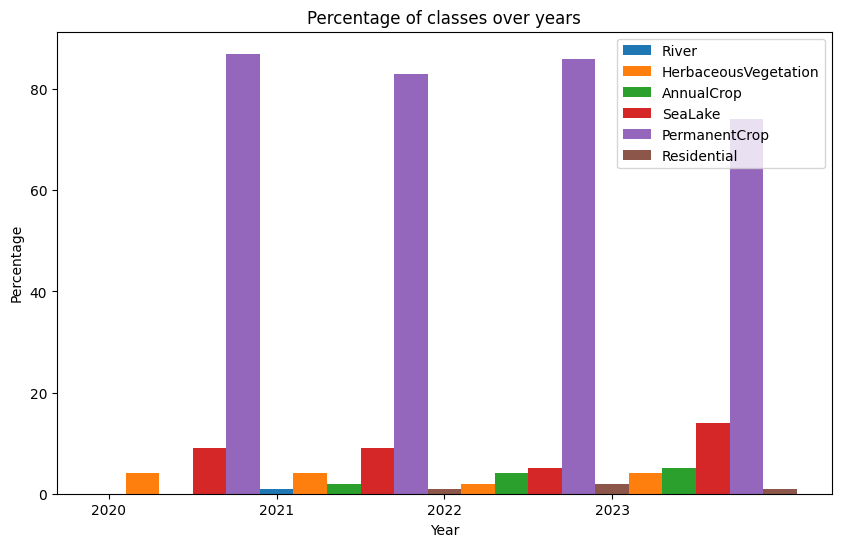

In [ ]:
data = class_percentages
sorted_data = sorted(data.items(), key=lambda x: int(x[0].split('_')[-1]))

# Extracting years and classes
years = [2020,2021,2022,2023]
class_data = [item[1] for item in sorted_data]
classes = list(set().union(*class_data))

# Mapping of class indices to their corresponding labels
class_labels = {
    0: 'Industrial',
    1: 'River',
    2: 'HerbaceousVegetation',
    3: 'AnnualCrop',
    4: 'SeaLake',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Forest',
    8: 'Highway',
    9: 'Residential'
}

# Plotting
plt.figure(figsize=(10, 6))

# Plot each class
for i, cls in enumerate(classes):
    heights = [year.get(cls, 0) for year in class_data]
    plt.bar([j + i*0.2 for j in range(len(years))], heights, width=0.2, label=f'{class_labels[cls]}')

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of classes over years')
plt.xticks(range(len(years)), years)  # Set x-axis ticks to display years
plt.legend()
plt.show()